In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

import pickle
import gzip

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.12.0


In [18]:
# Verificar disponibilidad de GPU y listar dispositivos físicos
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
    
    # Configurar crecimiento de memoria (evita que TensorFlow reserve toda la VRAM)
    tf.config.experimental.set_memory_growth(gpu, True)
    
    # Información adicional sobre la GPU
    print("\nDetalles de GPU:")
    from tensorflow.python.client import device_lib
    local_devices = device_lib.list_local_devices()
    for device in local_devices:
        if device.device_type == 'GPU':
            print(f"  Nombre: {device.physical_device_desc}")
else:
    print("No se detectó ninguna GPU. El entrenamiento usará CPU.")

GPUs disponibles: 1
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Detalles de GPU:
  Nombre: device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


I0000 00:00:1763949447.248323   12135 gpu_device.cc:2020] Created device /device:GPU:0 with 2857 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [19]:
# Cargar datos desde Keras
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Aplanar y normalizar
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# Convertir etiquetas a one-hot
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [20]:
# Hiperparámetros
learning_rate = 0.001
epochs = 15
batch_size = 10

# Construir modelo: [784, 30, 10]
model = Sequential()
model.add(Dense(30, activation='sigmoid', input_shape=(784,), 
                kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Dense(num_classes, activation='sigmoid',
                kernel_initializer='glorot_uniform', bias_initializer='zeros'))

model.summary()

/home/enriq/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763949548.214332   12135 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2857 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,860 (93.20 KB)

 Trainable params: 23,860 (93.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilar con Adam y binary crossentropy
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy'])

In [23]:
# Entrenar
history = model.fit(
    x_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test_cat))

Epoch 1/15


2025-11-23 20:01:37.888198: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a0194004090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-23 20:01:37.888243: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-11-23 20:01:37.973591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 20:01:38.219516: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


  41/6000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.1294 - loss: 0.6693 

I0000 00:00:1763949699.215691   17393 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.8613 - loss: 0.1035 - val_accuracy: 0.9250 - val_loss: 0.0519
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9305 - loss: 0.0466 - val_accuracy: 0.9377 - val_loss: 0.0414
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9418 - loss: 0.0388 - val_accuracy: 0.9454 - val_loss: 0.0370
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9491 - loss: 0.0344 - val_accuracy: 0.9485 - val_loss: 0.0347
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9546 - loss: 0.0314 - val_accuracy: 0.9526 - val_loss: 0.0328
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9577 - loss: 0.0293 - val_accuracy: 0.9536 - val_loss: 0.0318
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9611 - loss: 0.0275 - val_accuracy: 0.9537 - val_loss: 0.0306
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9636 - loss: 0.0261 - val

In [25]:
# Evaluar en conjunto de prueba
score = model.evaluate(x_test, y_test_cat, verbose=1)

print(f"\nPérdida: {score[0]:.4f}")
print(f"Precisión: {score[1]:.4f} ({score[1]*100:.2f}%)")
print(f"Correctos: {int(score[1] * len(x_test))} / {len(x_test)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9599 - loss: 0.0295

Pérdida: 0.0295
Precisión: 0.9599 (95.99%)
Correctos: 9599 / 10000


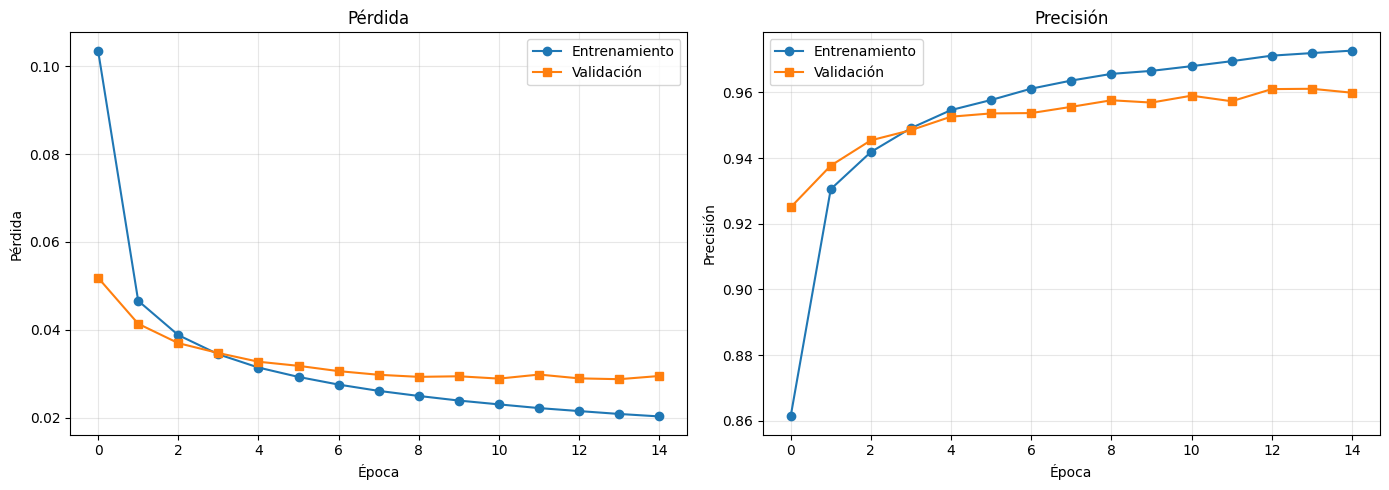

In [26]:
# Gráficas de pérdida y precisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pérdida
ax1.plot(history.history['loss'], label='Entrenamiento', marker='o')
ax1.plot(history.history['val_loss'], label='Validación', marker='s')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.set_title('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(history.history['accuracy'], label='Entrenamiento', marker='o')
ax2.plot(history.history['val_accuracy'], label='Validación', marker='s')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.set_title('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()